<a href="https://colab.research.google.com/github/pran872/Brain-Network/blob/main/level3_custom.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, random_split
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
from tqdm import tqdm
import numpy as np
import random

# Seed for reproducibility
seed = 42
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", device)


Device: cpu


In [2]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

full_train_set = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
train_size = int(0.9 * len(full_train_set))
val_size = len(full_train_set) - train_size
train_set, val_set = random_split(full_train_set, [train_size, val_size])

train_loader = DataLoader(train_set, batch_size=256, shuffle=True, num_workers=2)
val_loader = DataLoader(val_set, batch_size=256, shuffle=False, num_workers=2)

test_set = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)
test_loader = DataLoader(test_set, batch_size=256, shuffle=False, num_workers=2)


100%|██████████| 170M/170M [00:01<00:00, 87.5MB/s]


In [3]:
class Flex2D(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size, device, stride=1, padding=0, config=None):
        super().__init__()
        """
        # in dimensions: in this case [C, H, W]
        # --------
        # logits_mechanism: THRESHOLD or SPATIAL_ATTENTION_(1-3)
        # masking_mechanism: "SIGMOID", "STE", "SIGMOID_SMOOTHED", "STE_SIGMOID"
        # num_spatial_attention_block: int
        # logits_use_batchnorm: bool

        # about parameter vs variable:
        variable is almost deprecated and works the same as just plain tensor. And a Parameters is a specific Tensor that is marked as being a parameter from an nn.Module and so will be returned when calling .parameters() on this Module.
        """
        # -------- set configs --------
        # assert config, "Missing config file for Flex2D"
        # self.config = config
        self.in_channels = in_channels
        self.out_channels = out_channels
        self.kernel_size = kernel_size
        self.stride = stride
        self.padding = padding
        self.device = device

        # -------- Initialize layers --------
        self.flex_conv = nn.Conv2d(in_channels, out_channels, kernel_size, stride, padding)
        self.flex_pool = MaxPool2d(kernel_size, stride, padding)
        self.bn_logits = nn.BatchNorm2d(self.out_channels)

        # -------- Initialize monitored variables --------
        self.homogeneity = 0  # for monitoring the binariness of the mask later on
        self.conv_ratio = 0  # for later updating
        self.cp_identity_matrix = None  # store the matrix indicating the channel pool identity

    def channel_interpolate(self, tensor, out_channels):
        """
        Interpolates a tensor along the channel axis. This is for addressing the mismatch in the number of channels between the output of the maxpool layer and the output of the convolutional layer.
        """
        tensor = tensor.permute(0, 2, 1, 3)
        tensor = F.interpolate(tensor, [out_channels, tensor.size(3)], mode="bilinear")
        tensor = tensor.permute(0, 2, 1, 3)
        return tensor

    def channel_wise_maxpool(self, tensor_1, tensor_2):
        """
        Take two tensors of identical shape and return a tensor of the same shape using element-wise max pooling.
        Also returns the ratio of values from tensor_2 to the total.
        """
        assert tensor_1.shape == tensor_2.shape, "tensor_1 and tensor_2 must have the same shape"

        joint = cat([tensor_1.unsqueeze(-1), tensor_2.unsqueeze(-1)], dim=-1)
        pooled, indices = torch.max(joint, dim=-1)

        # count values are from conv (tensor 2)
        with torch.no_grad():
            conv_ratio = (indices == 1).sum().item() / tensor_1.numel()
            cp_identity_matrix = (indices == 1).int()

        return pooled, conv_ratio, cp_identity_matrix

    def forward(self, x):
        """
        threshold can only be initialized when the output dimensions are known
        """
        # -------- make the raw conv and pool --------
        t_flex_pool = self.flex_pool(x)
        t_flex_conv = self.flex_conv(x)
        t_flex_pool = self.channel_interpolate(t_flex_pool, self.out_channels)

        # -------- get the binary mask --------
        output, self.conv_ratio, self.cp_identity_matrix = self.channel_wise_maxpool(t_flex_pool, t_flex_conv)
        return output

In [4]:
class CustomViTHybrid(nn.Module):
    def __init__(self, img_size=32, patch_size=4, in_channels=3,
                 cnn_channels=32, embed_dim=64, depth=2, heads=4,
                 num_classes=10, use_flex=False, device="cpu"):
        super().__init__()

        self.use_flex = use_flex
        self.device = device

        # First conv layer
        self.conv1 = nn.Conv2d(in_channels, 16, kernel_size=3, padding=1)
        self.pool1 = nn.MaxPool2d(2)  # 32 → 16

        # Optional second layer: Flex2D or Conv
        if self.use_flex:
            self.flex = Flex2D(16, cnn_channels, kernel_size=3, stride=1, padding=1, device=self.device)
        else:
            self.conv2 = nn.Conv2d(16, cnn_channels, kernel_size=3, padding=1)
        self.pool2 = nn.MaxPool2d(2)  # 16 → 8

        # Patch embedding
        self.patch_embed = nn.Conv2d(cnn_channels, embed_dim, kernel_size=patch_size, stride=patch_size)
        num_patches = (8 // patch_size) ** 2

        # CLS token
        self.cls_token = nn.Parameter(torch.zeros(1, 1, embed_dim))

        # Positional embedding
        self.pos_embed = nn.Parameter(torch.zeros(1, num_patches + 1, embed_dim))
        nn.init.trunc_normal_(self.pos_embed, std=0.02)

        # ViT encoder
        encoder_layer = nn.TransformerEncoderLayer(d_model=embed_dim, nhead=heads, batch_first=True)
        self.transformer = nn.TransformerEncoder(encoder_layer, num_layers=depth)

        # Classifier
        self.mlp_head = nn.Sequential(
            nn.LayerNorm(embed_dim),
            nn.Linear(embed_dim, num_classes)
        )

    def forward(self, x):
        B = x.size(0)
        x = F.relu(self.conv1(x))
        x = self.pool1(x)

        if self.use_flex:
            x = self.flex(x)
        else:
            x = F.relu(self.conv2(x))
        x = self.pool2(x)

        x = self.patch_embed(x)                      # [B, embed_dim, H', W']
        x = x.flatten(2).transpose(1, 2)             # [B, num_patches, embed_dim]

        cls_tokens = self.cls_token.expand(B, -1, -1)
        x = torch.cat((cls_tokens, x), dim=1)
        x = x + self.pos_embed

        x = self.transformer(x)
        x = x[:, 0]  # Use CLS token
        return self.mlp_head(x)


In [5]:
model = CustomViTHybrid(use_flex=True).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss()

train_losses, val_losses = [], []
train_accuracies, val_accuracies = [], []


In [6]:
def train_model(epochs=5):
    for epoch in range(epochs):
        model.train()
        total_loss, correct, total = 0, 0, 0

        for images, labels in tqdm(train_loader, desc=f"Epoch {epoch+1} [Train]"):
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            total_loss += loss.item()
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()

        train_losses.append(total_loss / len(train_loader))
        train_accuracies.append(100. * correct / total)

        # Validation
        model.eval()
        val_loss, correct, total = 0, 0, 0
        with torch.no_grad():
            for images, labels in tqdm(val_loader, desc=f"Epoch {epoch+1} [Val]"):
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                loss = criterion(outputs, labels)
                val_loss += loss.item()
                _, predicted = outputs.max(1)
                total += labels.size(0)
                correct += predicted.eq(labels).sum().item()

        val_losses.append(val_loss / len(val_loader))
        val_accuracies.append(100. * correct / total)
        print(f"Epoch {epoch+1}: Train Acc={train_accuracies[-1]:.2f}% | Val Acc={val_accuracies[-1]:.2f}%")


In [7]:
def test_model():
    model.eval()
    correct, total = 0, 0
    with torch.no_grad():
        for images, labels in tqdm(test_loader, desc="Testing"):
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()

    print(f"Test Accuracy: {100 * correct / total:.2f}%")

train_model(epochs=10)
test_model()


Epoch 1 [Val]: 100%|██████████| 20/20 [00:04<00:00,  4.48it/s]


Epoch 1: Train Acc=27.23% | Val Acc=40.42%


Epoch 2 [Val]: 100%|██████████| 20/20 [00:03<00:00,  6.06it/s]


Epoch 2: Train Acc=44.38% | Val Acc=50.82%


Epoch 3 [Val]: 100%|██████████| 20/20 [00:03<00:00,  6.15it/s]


Epoch 3: Train Acc=51.52% | Val Acc=55.12%


Epoch 4 [Val]: 100%|██████████| 20/20 [00:03<00:00,  6.03it/s]


Epoch 4: Train Acc=56.03% | Val Acc=59.66%


Epoch 5 [Val]: 100%|██████████| 20/20 [00:04<00:00,  4.51it/s]


Epoch 5: Train Acc=59.56% | Val Acc=60.48%


Epoch 6 [Val]: 100%|██████████| 20/20 [00:03<00:00,  5.26it/s]


Epoch 6: Train Acc=62.98% | Val Acc=63.40%


Epoch 7 [Val]: 100%|██████████| 20/20 [00:03<00:00,  6.07it/s]


Epoch 7: Train Acc=65.38% | Val Acc=64.58%


Epoch 8 [Val]: 100%|██████████| 20/20 [00:03<00:00,  6.09it/s]


Epoch 8: Train Acc=67.50% | Val Acc=66.58%


Epoch 9 [Val]: 100%|██████████| 20/20 [00:03<00:00,  5.00it/s]


Epoch 9: Train Acc=69.36% | Val Acc=66.24%


Epoch 10 [Val]: 100%|██████████| 20/20 [00:03<00:00,  5.92it/s]


Epoch 10: Train Acc=70.88% | Val Acc=67.04%


Testing: 100%|██████████| 40/40 [00:06<00:00,  6.52it/s]

Test Accuracy: 67.21%


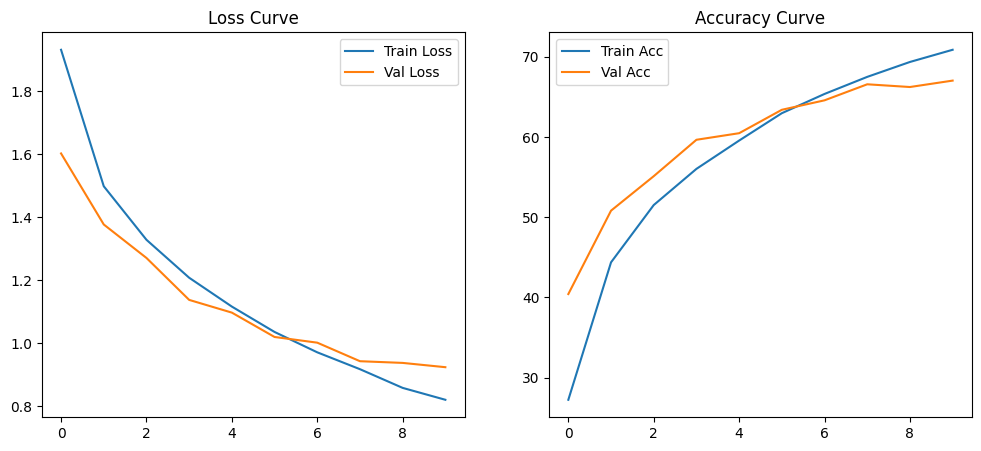

In [8]:
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Val Loss')
plt.legend()
plt.title('Loss Curve')

plt.subplot(1, 2, 2)
plt.plot(train_accuracies, label='Train Acc')
plt.plot(val_accuracies, label='Val Acc')
plt.legend()
plt.title('Accuracy Curve')

plt.show()
